<a href="https://colab.research.google.com/github/felipemaiapolo/master_thesis/blob/master/Density_ratio_estimation_using_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
base<-read.table("analise_clusters_v2.csv", sep=";", header=T, encoding = "UTF-8")

In [0]:
base[4:9,]

,id_lepes,O_p_ano,C_p_ano,E_p_ano,A_p_ano,N_p_ano,genero,brancos,tipo_escola,bf,⋯,q35,q36,q37,q38,q39,q40,q41,q42,q43,q44
4,4,0.1078064,-1.6895670,-0.2406949,-0.3358859,1.049038,0,NA,1,1,⋯,4,3,4,4,2,3,2,1,1,3
5,5,0.4184995,-0.0413650,1.2306430,0.4752485,0.433447,0,0,1,0,⋯,3,1,5,1,3,4,2,2,1,4
6,5,NA,NA,NA,NA,NA,0,0,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,7,0.4626869,1.6712680,-0.3203712,0.6795036,1.256023,1,NA,1,0,⋯,2,1,4,3,5,5,5,5,1,5
8,8,1.1996710,1.4505940,0.7209620,0.4257135,1.854306,1,0,1,NA,⋯,5,1,1,1,5,1,5,4,1,3
9,8,0.3485188,-0.0131268,-0.2865033,0.2369193,0.257794,1,0,1,NA,⋯,5,3,2,1,4,4,3,3,3,4


In [0]:
install.packages("bayesplot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [0]:
library(rstanarm)
library(BART)
library(pROC)
library(parallel)
library(dummies)
library(plyr)  
library(iml)
library(ggplot2)
library(bayesplot)
#library(Rcpp)

Número de núcleos no CPU

In [0]:
detectCores(all.tests = FALSE, logical = TRUE)

[1] 4

Criando painel curto

In [0]:
sem=c('O','C','E','A','N')
  
#Separando variáveis
vars<-c('id_lepes','O_p_ano','C_p_ano','E_p_ano','A_p_ano','N_p_ano', 'mat_12', 'port_12', 'mat_17', 'port_17',
          'educmae1','educmae2','educmae3','educmae4','educmae5','educmae6',
          'serie','genero','brancos','tipo_escola','sobreviventes','escola','idade','reprov_antes_12','bf')
  
#Separando bases por ano
base12<-subset(base,tempo==2012)[c(vars)]
names(base12)<-c('id_lepes','O_p_12','C_p_12','E_p_12','A_p_12','N_p_12', 'mat_12', 'port_12', 'mat_17', 'port_17',
                   'educmae1','educmae2','educmae3','educmae4','educmae5','educmae6',
                   'serie','genero','brancos','tipo_escola_12','sobreviventes','escola_12','idade_12','reprov_antes_12','bf_12')
base12<-base12[c('id_lepes','O_p_12','C_p_12','E_p_12','A_p_12','N_p_12', 'mat_12', 'port_12', 
                   'educmae1','educmae2','educmae3','educmae4','educmae5','educmae6',
                   'serie','genero','brancos','tipo_escola_12','sobreviventes','escola_12','idade_12','reprov_antes_12','bf_12')]
  
base17<-subset(base,tempo==2017)[c(vars)]
names(base17)<-c('id_lepes','O_p_17','C_p_17','E_p_17','A_p_17','N_p_17', 'mat_12', 'port_12', 'mat_17', 'port_17',
                   'educmae1','educmae2','educmae3','educmae4','educmae5','educmae6',
                   'serie','genero','brancos','tipo_escola_17','sobreviventes','escola_17','idade_17','reprov_antes_12','bf_17')
base17<-base17[c('id_lepes','O_p_17','C_p_17','E_p_17','A_p_17','N_p_17', 'mat_17', 'port_17', 
                   'educmae1','educmae2','educmae3','educmae4','educmae5','educmae6',
                   'serie','genero','brancos','tipo_escola_17','sobreviventes','escola_17','idade_17','reprov_antes_12','bf_17')]

Criando painel que os indivíduos são aqueles que estavam em 2012

In [0]:
painel<-merge(base12,base17,by="id_lepes",all.x = T)

Consolidando variáveis

In [0]:
painel$reprov_antes_12<-ifelse(is.na(painel$reprov_antes_12.x),painel$reprov_antes_12.y,painel$reprov_antes_12.x)
  
painel$genero<-ifelse(!is.na(painel$genero.y),painel$genero.y,painel$genero.x)
painel$brancos<-ifelse(!is.na(painel$brancos.y),painel$brancos.y,painel$brancos.x)
  
names(painel)[names(painel) == 'serie.x'] <- 'serie_12'
names(painel)[names(painel) == 'serie.y'] <- 'serie_17'
  
#names(painel)[names(painel) == 'tipo_escola.x'] <- 'tipo_escola_12'
#names(painel)[names(painel) == 'tipo_escola.y'] <- 'tipo_escola_17'

names(painel)[names(painel) == 'sobreviventes.x'] <- 'sobreviventes'
  
for(i in 1:6){
    names(painel)[names(painel) == paste('educmae',i,'.x',sep="")] <- paste('educmae',i,'_12',sep="")
    names(painel)[names(painel) == paste('educmae',i,'.y',sep="")] <- paste('educmae',i,'_17',sep="")
}
 
#Unificando educmae
#painel$educmae_12<-as.numeric(apply(painel %>% select(educmae1_12:educmae6_12),1,which.max))

#Criando variável Y
painel$distorcao<-ifelse(is.na(painel$serie_12) | is.na(painel$serie_17), NA,
                                  ifelse(painel$serie_12==4 & painel$serie_17>=9, 0,
                                         ifelse(painel$serie_12==5 & painel$serie_17>=10, 0,
                                                ifelse(painel$serie_12==6 & painel$serie_17>=11, 0, 1))))

Mantendo pessoas que n estavam no 4 ano em 2012

In [0]:
painel<-subset(painel, serie_12!=4)

Checando variáveis

In [0]:
names(painel)

[1] "id_lepes"          "O_p_12"            "C_p_12"           
 [4] "E_p_12"            "A_p_12"            "N_p_12"           
 [7] "mat_12"            "port_12"           "educmae1_12"      
[10] "educmae2_12"       "educmae3_12"       "educmae4_12"      
[13] "educmae5_12"       "educmae6_12"       "serie_12"         
[16] "genero.x"          "brancos.x"         "tipo_escola_12"   
[19] "sobreviventes"     "escola_12"         "idade_12"         
[22] "reprov_antes_12.x" "bf_12"             "O_p_17"           
[25] "C_p_17"            "E_p_17"            "A_p_17"           
[28] "N_p_17"            "mat_17"            "port_17"          
[31] "educmae1_17"       "educmae2_17"       "educmae3_17"      
[34] "educmae4_17"       "educmae5_17"       "educmae6_17"      
[37] "serie_17"          "genero.y"          "brancos.y"        
[40] "tipo_escola_17"    "sobreviventes.y"   "escola_17"        
[43] "idade_17"          "reprov_antes_12.y" "bf_17"            
[46] "reprov_antes_12"   "genero"            "brancos"          
[49] "distorcao"

Vendo melhor a variável de interesse:

In [0]:
summary(painel['distorcao'])

   distorcao     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.1341  
 3rd Qu.:0.0000  
 Max.   :1.0000  
 NA's   :1140    

Selecionando variáveis

In [0]:
data=as.data.frame(painel[,c('O_p_12','C_p_12','E_p_12','A_p_12','N_p_12',
                          'serie_12','escola_12','mat_12','port_12',
                          'educmae1_12', 'educmae2_12', 'educmae3_12', 'educmae4_12', 'educmae5_12', 'educmae6_12',
                          'genero','brancos','reprov_antes_12',#'bf_12','tipo_escola_12',
                          'distorcao')])

dim(data)

[1] 3116   19

Tirando missings

In [0]:
data=na.omit(data)
dim(data)

[1] 1831   19

Criando dummy de escola

In [0]:
dummies <- dummy.data.frame(data, names = c('escola_12') , sep = ".")

X=dummies[,-NCOL(dummies)]
y=dummies[,'distorcao']

names(X)

[1] "O_p_12"                                              
 [2] "C_p_12"                                              
 [3] "E_p_12"                                              
 [4] "A_p_12"                                              
 [5] "N_p_12"                                              
 [6] "serie_12"                                            
 [7] "escola_12.ALFEU RODRIGUES SANTINHO EMEF MANNA ENSINO"
 [8] "escola_12.ANGELO COLAFEMINA EMEF"                    
 [9] "escola_12.ANITA BARTOLETTE RODRIGUES EMEF"           
[10] "escola_12.ANNA PASSAMONTI BALARDIN"                  
[11] "escola_12.ANTONIO FURLAN JUNIOR DOUTOR"              
[12] "escola_12.CAMINHO SUAVE ESCOLA GA"                   
[13] "escola_12.COLEGIO ARTE LIVRE"                        
[14] "escola_12.DOUTOR SILVIO SARTI EMEF"                  
[15] "escola_12.EDITH SILVEIRA DALMASO PROFESSORA"         
[16] "escola_12.EDUCAR COLEGIO"                            
[17] "escola_12.ELYDIA CARNEIRO DA ROCHA EMEF"             
[18] "escola_12.FERRUCIO CHIARATTI"                        
[19] "escola_12.ISAIAS JOSE FERREIRA DOUTOR"               
[20] "escola_12.MARIA APARECIDA O BELLINI EMEF"            
[21] "escola_12.MARIA CONCEICAO R S MAGON PROFA"           
[22] "escola_12.MARIA NELI M TONIELO PREF EMEIF"           
[23] "escola_12.MARILENA ARANTES MENEGHINI EMEF"           
[24] "escola_12.NICIA FABIOLA Z GIRALDI PROFA"             
[25] "escola_12.PROF ANTONIO CRISTINO CABRAL EMEF"         
[26] "escola_12.PROF RAUL DO PRADO VIANNA EMEF"            
[27] "escola_12.PROFA ELVIRA ARRUDA DE SOUZA EMEF"         
[28] "escola_12.PROFA JOANNINHA GILBERTI EMEF"             
[29] "escola_12.PROFA NAIR TEIXEIRA ORTOLAN EMEF"          
[30] "escola_12.PROFESSOR ANACLETO CRUZ EMEF"              
[31] "escola_12.PROFESSOR JOSE NEGRI EMEF"                 
[32] "escola_12.RENASCER CENTRO EDUCACIONAL"               
[33] "escola_12.ROBERTO ZANUTTO DESIDERIO EMEF"            
[34] "escola_12.SESI 241"                                  
[35] "escola_12.TECNO SERT COLEGIO"                        
[36] "escola_12.WALDOMIRO GOMES EMEF"                      
[37] "escola_12.WINSTON CHURCHILL"                         
[38] "mat_12"                                              
[39] "port_12"                                             
[40] "educmae1_12"                                         
[41] "educmae2_12"                                         
[42] "educmae3_12"                                         
[43] "educmae4_12"                                         
[44] "educmae5_12"                                         
[45] "educmae6_12"                                         
[46] "genero"                                              
[47] "brancos"                                             
[48] "reprov_antes_12"

In [0]:
X=data[,-NCOL(data)]     
y=data[,'distorcao']

In [0]:
set.seed(4)
index_train<-sample(seq_len(nrow(X)),size=1000)

In [0]:
ntree=300
k=2

#thin=5

In [0]:
post=mc.pbart(X[index_train,], y[index_train], X[-index_train,], ntree=ntree, k=k, rho=NCOL(X),
              sparse=TRUE, nskip=2000, ndpost=1000, mc.cores=4)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0,7249

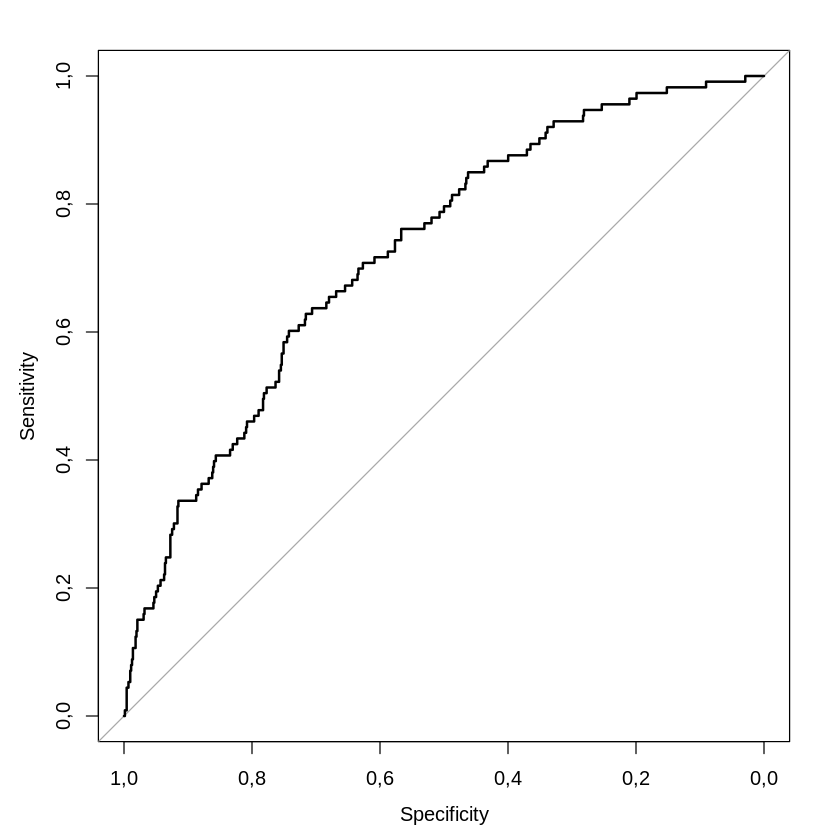

In [0]:
# Predict results
post$prob.test <- pnorm(post$yhat.test)
results_prob <- apply(post$prob.test, 2, mean)

# Actual answers
answers <- y[-index_train]

#AUC
roc_obj_bart <- roc(answers, results_prob)
roc_obj_bart$auc

plot(roc_obj_bart)

In [0]:
names(X)

[1] "O_p_12"          "C_p_12"          "E_p_12"          "A_p_12"         
 [5] "N_p_12"          "serie_12"        "escola_12"       "mat_12"         
 [9] "port_12"         "educmae1_12"     "educmae2_12"     "educmae3_12"    
[13] "educmae4_12"     "educmae5_12"     "educmae6_12"     "genero"         
[17] "brancos"         "reprov_antes_12"

In [0]:
ntree=300
k=2
thin=150

In [0]:
start.time <- Sys.time()

In [0]:
set.seed(42)
post=mc.pbart(X[index_train,],y[index_train],X[-index_train,], ntree=ntree, k=k, rho=NCOL(X),
           sparse=TRUE, nskip=50000, ndpost=10000, keepevery=thin, mc.cores=4)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0,7304

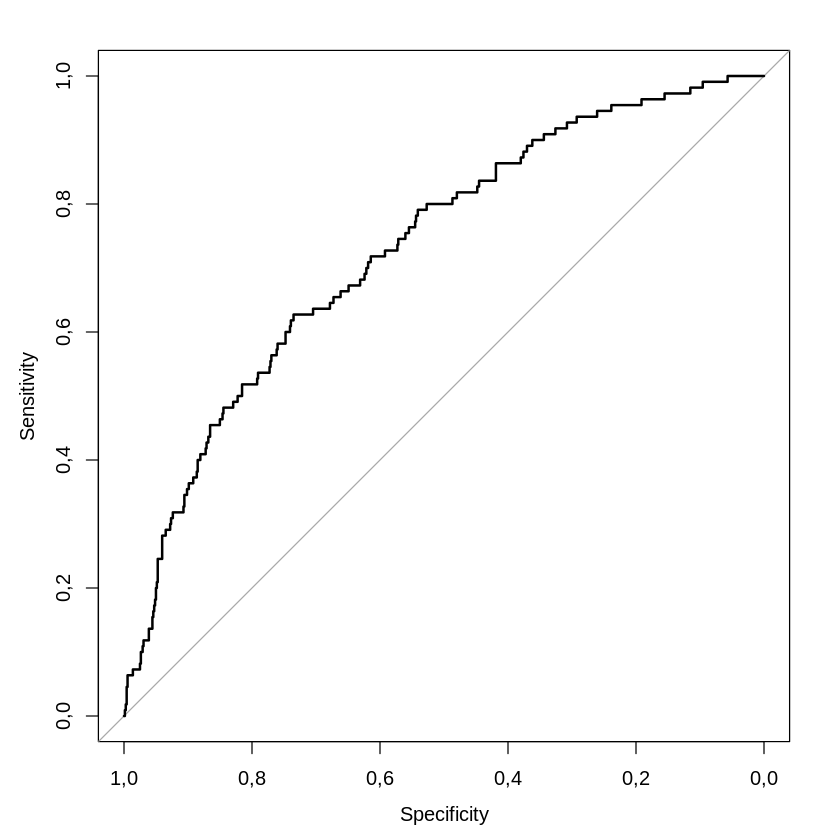

In [0]:
# Predict results
post$prob.test <- pnorm(post$yhat.test)
results_prob <- apply(post$prob.test, 2, mean)

# Actual answers
answers <- y[-index_train]

#AUC
roc_obj_bart <- roc(answers, results_prob)
roc_obj_bart$auc

plot(roc_obj_bart)


	Two-sample Kolmogorov-Smirnov test

data:  z and z2
D = 0,081552, p-value = 0,000153
alternative hypothesis: two-sided


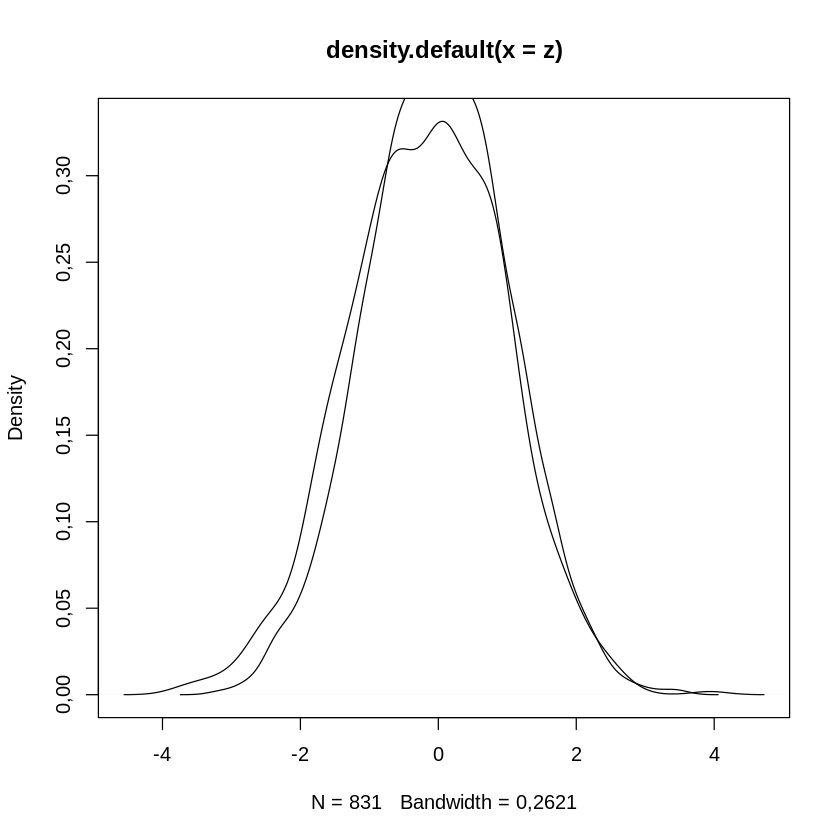

In [0]:
post.mcmc <- pnorm(post$yhat.test)
z <- gewekediag(post.mcmc, frac1=0.1, frac2=0.5)$z

z2<-rnorm(5000) #NROW(X[-index_train,])

plot(density(z))
lines(density(z2))
ks.test(z, z2)


	Two-sample Kolmogorov-Smirnov test

data:  z and z2
D = 0,072473, p-value = 0,001123
alternative hypothesis: two-sided


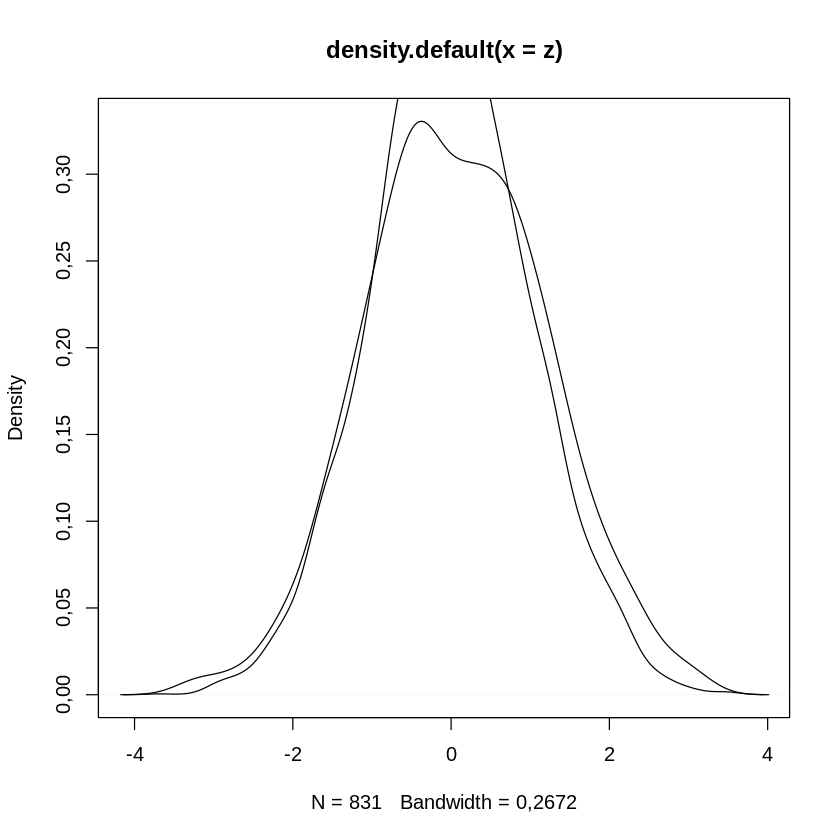

In [0]:
post.mcmc <- pnorm(post$yhat.test)
z <- gewekediag(post.mcmc, frac1=0.2, frac2=0.5)$z

z2<-rnorm(5000) #NROW(X[-index_train,])

plot(density(z))
lines(density(z2))
ks.test(z, z2)


	Two-sample Kolmogorov-Smirnov test

data:  z and z2
D = 0,042839, p-value = 0,1462
alternative hypothesis: two-sided


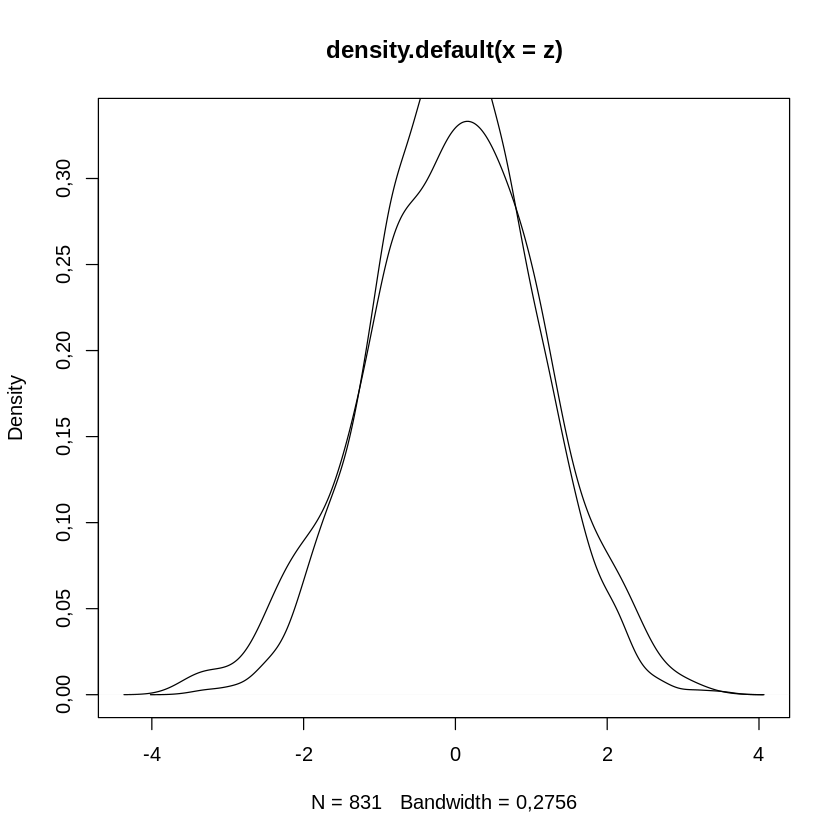

In [0]:
post.mcmc <- pnorm(post$yhat.test)
z <- gewekediag(post.mcmc, frac1=0.3, frac2=0.5)$z

z2<-rnorm(5000) #NROW(X[-index_train,])

plot(density(z))
lines(density(z2))
ks.test(z, z2)


	Two-sample Kolmogorov-Smirnov test

data:  z and z2
D = 0,045345, p-value = 0,1067
alternative hypothesis: two-sided


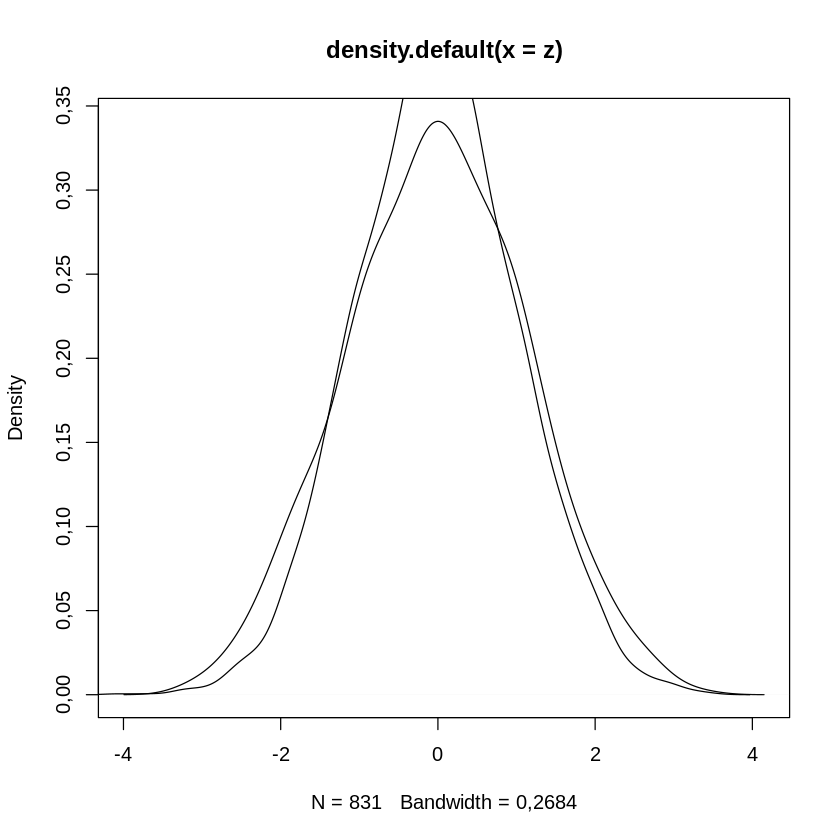

In [0]:
post.mcmc <- pnorm(post$yhat.test)
z <- gewekediag(post.mcmc, frac1=0.4, frac2=0.5)$z

z2<-rnorm(5000) #NROW(X[-index_train,])

plot(density(z))
lines(density(z2))
ks.test(z, z2)


	Two-sample Kolmogorov-Smirnov test

data:  z and z2
D = 0,04922, p-value = 0,06333
alternative hypothesis: two-sided


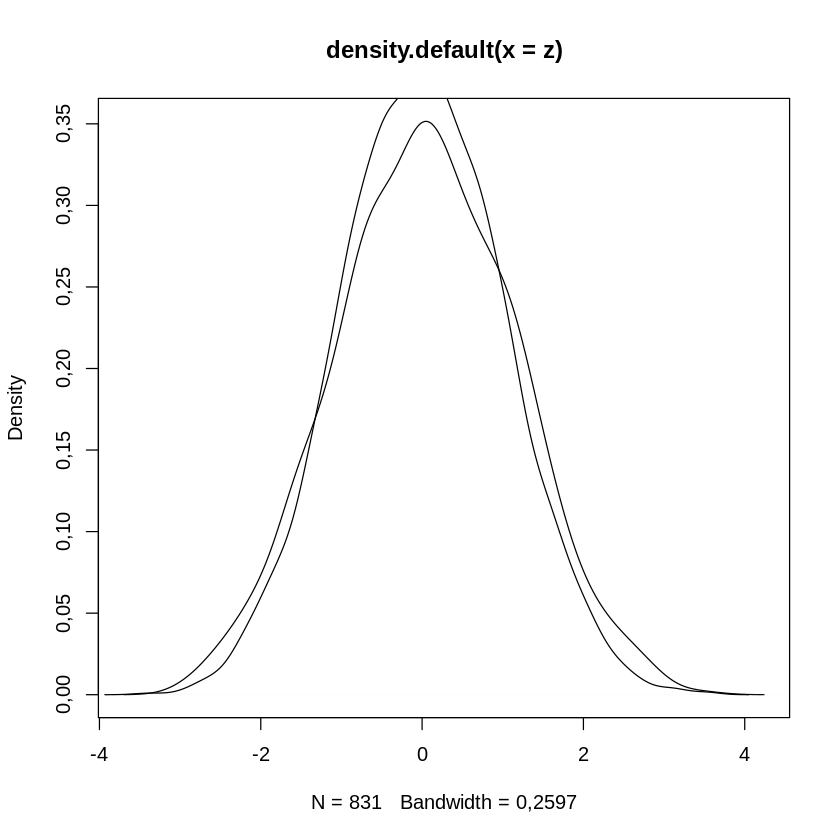

In [0]:
post.mcmc <- pnorm(post$yhat.test)
z <- gewekediag(post.mcmc, frac1=0.4, frac2=0.4)$z

z2<-rnorm(5000) #NROW(X[-index_train,])

plot(density(z))
lines(density(z2))
ks.test(z, z2)

In [0]:
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 3,216864 hours

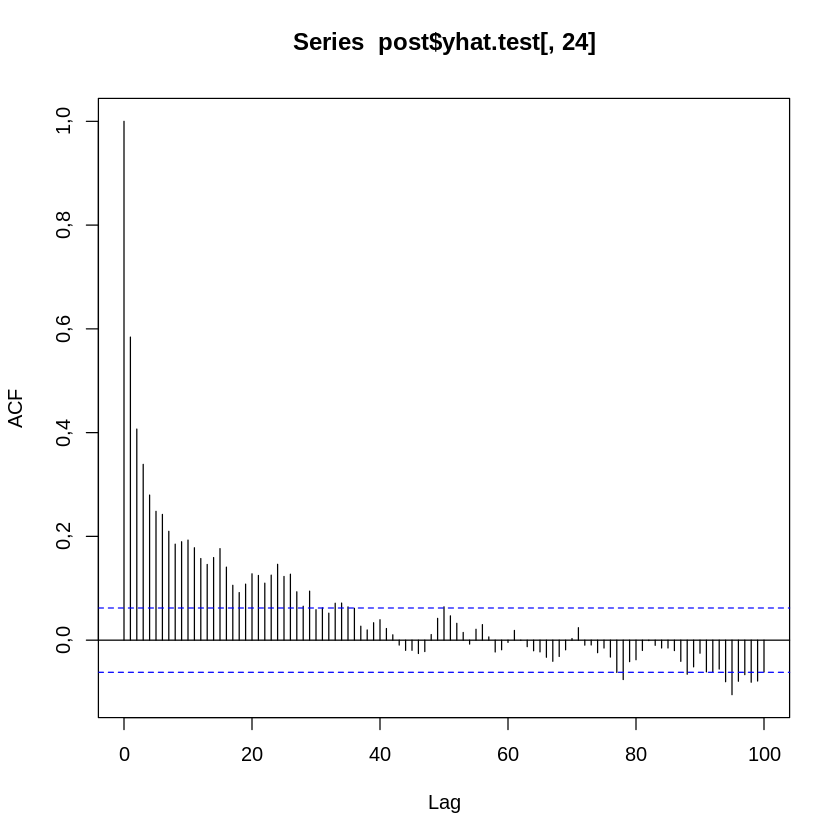

In [0]:
acf(post$yhat.test[,24],lag.max=100)

In [0]:
var_select<-apply((post$varcount>0), 2, mean)
var_select

O_p_12 
                                               0,315 
                                              C_p_12 
                                               1,000 
                                              E_p_12 
                                               0,216 
                                              A_p_12 
                                               0,111 
                                              N_p_12 
                                               0,243 
                                            serie_12 
                                               1,000 
escola_12.ALFEU RODRIGUES SANTINHO EMEF MANNA ENSINO 
                                               0,293 
                    escola_12.ANGELO COLAFEMINA EMEF 
                                               0,082 
           escola_12.ANITA BARTOLETTE RODRIGUES EMEF 
                                               0,252 
                  escola_12.ANNA PASSAMONTI BALARDIN 
                                               0,374 
              escola_12.ANTONIO FURLAN JUNIOR DOUTOR 
                                               0,086 
                   escola_12.CAMINHO SUAVE ESCOLA GA 
                                               0,000 
                        escola_12.COLEGIO ARTE LIVRE 
                                               0,280 
                  escola_12.DOUTOR SILVIO SARTI EMEF 
                                               0,186 
         escola_12.EDITH SILVEIRA DALMASO PROFESSORA 
                                               0,484 
                            escola_12.EDUCAR COLEGIO 
                                               0,277 
             escola_12.ELYDIA CARNEIRO DA ROCHA EMEF 
                                               0,365 
                        escola_12.FERRUCIO CHIARATTI 
                                               0,165 
               escola_12.ISAIAS JOSE FERREIRA DOUTOR 
                                               0,187 
            escola_12.MARIA APARECIDA O BELLINI EMEF 
                                               0,197 
           escola_12.MARIA CONCEICAO R S MAGON PROFA 
                                               0,173 
           escola_12.MARIA NELI M TONIELO PREF EMEIF 
                                               0,261 
           escola_12.MARILENA ARANTES MENEGHINI EMEF 
                                               0,432 
             escola_12.NICIA FABIOLA Z GIRALDI PROFA 
                                               0,215 
         escola_12.PROF ANTONIO CRISTINO CABRAL EMEF 
                                               1,000 
            escola_12.PROF RAUL DO PRADO VIANNA EMEF 
                                               0,360 
         escola_12.PROFA ELVIRA ARRUDA DE SOUZA EMEF 
                                               0,289 
             escola_12.PROFA JOANNINHA GILBERTI EMEF 
                                               0,280 
          escola_12.PROFA NAIR TEIXEIRA ORTOLAN EMEF 
                                               0,329 
              escola_12.PROFESSOR ANACLETO CRUZ EMEF 
                                               0,275 
                 escola_12.PROFESSOR JOSE NEGRI EMEF 
                                               1,000 
               escola_12.RENASCER CENTRO EDUCACIONAL 
                                               0,420 
            escola_12.ROBERTO ZANUTTO DESIDERIO EMEF 
                                               0,240 
                                  escola_12.SESI 241 
                                               0,579 
                        escola_12.TECNO SERT COLEGIO 
                                               0,172 
                      escola_12.WALDOMIRO GOMES EMEF 
                                               0,249 
                         escola_12.WINSTON CHURCHILL 
                                               0,419 
                                              mat_

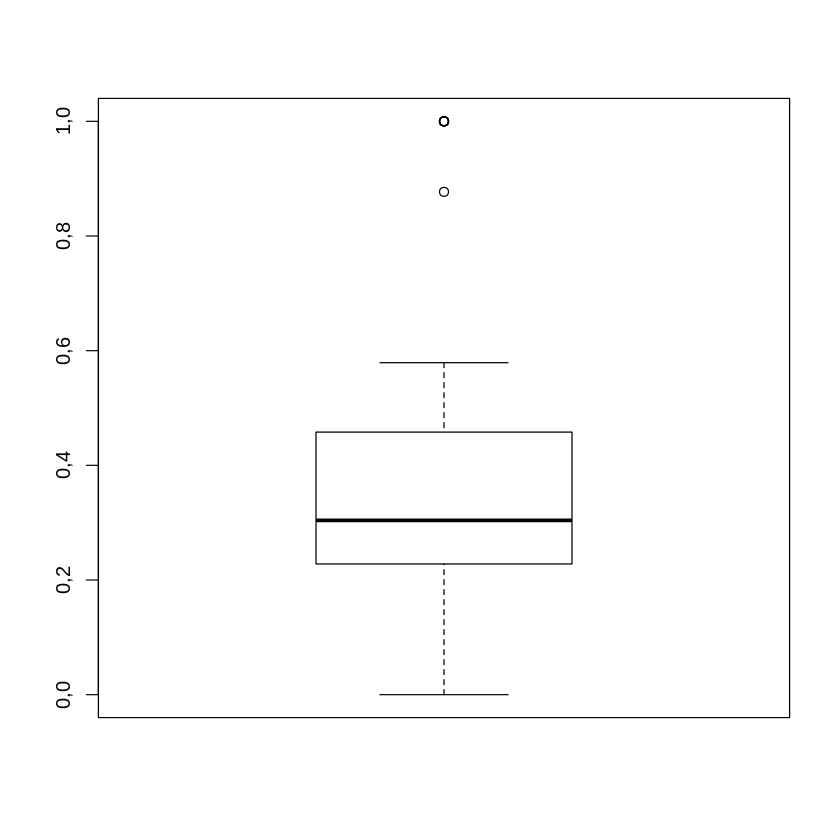

In [0]:
boxplot(var_select)

In [0]:
pred_fun<-function(model,newdata){
  pred=predict(model,newdata)
  return(apply(pnorm(pred$yhat.test), 2, mean))
}

In [0]:
plots<-list()

for (sem in c('O','C','E','A','N')){
  var=paste(sem,'_p_12' ,sep='')
  predictor = Predictor$new(post, data = X, predict.fun=pred_fun) #
  eff = FeatureEffect$new(predictor, var, method = "pdp+ice", grid.size = 20, center.at =-2) #min(data[,var]) pdp+ice
  #eff$results=eff$results[eff$results[,2]=="X1",]
  plots[[sem]]<-eff$plot()+xlim(-2,2) + ylim(-.05,.05)
}

In [0]:
gridExtra::grid.arrange(plots[["O"]], plots[["C"]], plots[["E"]], plots[["A"]],plots[["N"]], nrow = 2)